In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Class distribution after SMOTE: (array([0, 1]), array([1386101, 1386101]))
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10829/10829 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.9811 - loss: 0.0758 - val_accuracy: 0.9737 - val_loss: 0.0680 - learning_rate: 0.0010
Epoch 2/50
10829/10829 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.9855 - loss: 0.0512 - val_accuracy: 0.9834 - val_loss: 0.0613 - learning_rate: 0.0010
Epoch 3/50
10829/10829 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.9875 - loss: 0.0497 - val_accuracy: 0.9883 - val_loss: 0.0415 - learning_rate: 0.0010
Epoch 4/50
10829/10829 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 0.9878 - loss: 0.0444 - val_accuracy: 0.9776 - val_loss: 0.0694 - learning_rate: 0.0010
Epoch 5/50
10829/10829 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.9869 - loss: 0.0448 - val_accuracy: 0.9883 - val_loss: 0.0373 - learning_rate: 0.0010
Epoch 6/50
10829/10829 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 0.9867 - loss: 0.0470 - val_accuracy: 0.9844 - val_loss: 0.0486 - learning_rate: 0.0010
Epoch 7/50
10829/10829 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


15422/15439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


15439/15439 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step

Cross Dataset Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    494020

    accuracy                           1.00    494020
   macro avg       1.00      1.00      1.00    494020
weighted avg       1.00      1.00      1.00    494020


Cross Dataset Confusion Matrix:
[[494020]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


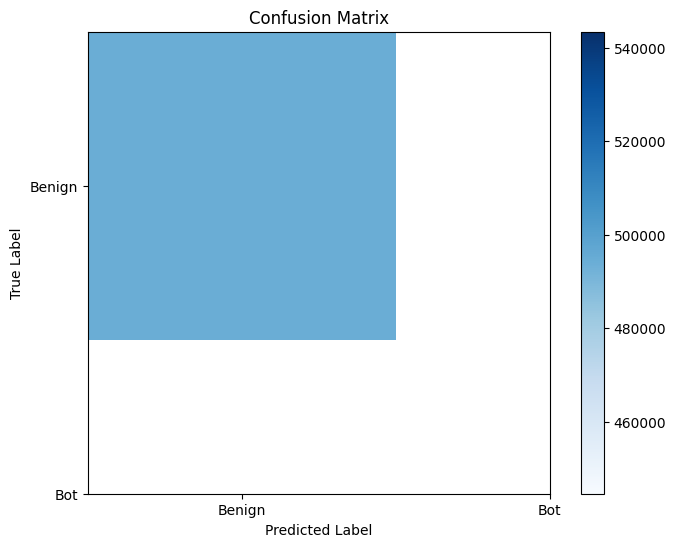

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, Dropout, Input, LayerNormalization, MultiHeadAttention, Add, Flatten, Reshape
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


# Step 1: Load and preprocess data
def load_and_preprocess_data(file_path, label_column=' Label'):
    data = pd.read_csv(file_path)

    # Check if label column exists
    if label_column not in data.columns:
        raise KeyError(f"The specified label column '{label_column}' is missing in the dataset.")

    # Encode target labels for kddcup99 dataset (update this logic for different label meanings)
    if label_column.lower() == 'label':
        data[label_column] = data[label_column].apply(lambda x: 1 if 'attack' in str(x).lower() else 0)
    else:
        data[label_column] = data[label_column].apply(lambda x: 1 if x.strip() == 'Bot' else 0)

    # Handle non-numeric columns
    non_numeric_cols = data.select_dtypes(exclude=[np.number]).columns
    if len(non_numeric_cols) > 0:
        print(f"Encoding non-numeric columns: {non_numeric_cols}")
        for col in non_numeric_cols:
            encoder = LabelEncoder()
            data[col] = encoder.fit_transform(data[col])

    # Handle missing and infinite values
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.fillna(data.mean(), inplace=True)

    # Select numeric columns only
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    data = data[numeric_cols]

    # Split features and labels
    X = data.drop(columns=[label_column])
    y = data[label_column]
    return X, y


# Step 2: Balance the training data using SMOTE
def balance_training_data(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    print("Class distribution after SMOTE:", np.unique(y_train_smote, return_counts=True))
    return X_train_smote, y_train_smote


# Step 3: Build Transformer-based model
def build_transformer_model(input_dim, num_heads=4, key_dim=64, dense_units=128, dropout_rate=0.4):
    inputs = Input(shape=(input_dim,))
    reshaped_inputs = Reshape((1, input_dim))(inputs)
    x = Dense(dense_units, activation='relu', kernel_regularizer=l2(1e-4))(reshaped_inputs)
    x = Dropout(dropout_rate)(x)
    norm1 = LayerNormalization()(x)
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(norm1, norm1)
    attn_output = Add()([x, attn_output])
    norm2 = LayerNormalization()(attn_output)
    dense_output = Dense(dense_units, activation='relu', kernel_regularizer=l2(1e-4))(norm2)
    dense_output = Add()([attn_output, dense_output])
    flatten_output = Flatten()(dense_output)
    x = Dense(dense_units // 2, activation='relu', kernel_regularizer=l2(1e-4))(flatten_output)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)  # Binary classification
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Step 4: Train the model
def train_model(model, X_train, y_train, X_val, y_val, class_weights):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=256,
        class_weight=class_weights,
        callbacks=[early_stopping, lr_scheduler]
    )
    return history


# Step 5: Evaluate on Cross Dataset
def evaluate_on_cross_dataset(model, X_test, y_test):
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    print("\nCross Dataset Classification Report:")
    print(classification_report(y_test, y_pred))

    print("\nCross Dataset Confusion Matrix:")
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(conf_matrix)

    plt.figure(figsize=(8, 6))
    plt.title("Confusion Matrix")
    plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
    plt.colorbar()
    plt.xticks([0, 1], ["Benign", "Bot"])
    plt.yticks([0, 1], ["Benign", "Bot"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


# Align features of the cross dataset with training dataset
def align_features(X_train, X_test):
    """
    Aligns the columns of X_test to match X_train.
    Missing columns in X_test are filled with zeros.
    Extra columns in X_test are dropped.
    """
    X_test_aligned = X_test.reindex(columns=X_train.columns, fill_value=0)
    return X_test_aligned


# Main Script
if __name__ == "__main__":
    # Dataset 1 (Training and Validation)
    file_path_train = '/content/drive/MyDrive/archive/merged_dst.csv'
    X, y = load_and_preprocess_data(file_path_train)

    # Split data into train+validation and test sets
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

    # Split train+validation into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.3, stratify=y_temp, random_state=42)

    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Balance the training data
    X_train, y_train = balance_training_data(X_train, y_train)

    # Compute class weights
    class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(class_weights))

    # Build and train the model
    model = build_transformer_model(input_dim=X_train.shape[1])
    history = train_model(model, X_train, y_train, X_val, y_val, class_weights)

    # Dataset 2 (Cross Dataset Validation)
    file_path_test = '/content/drive/MyDrive/kddcup99.csv'
    X_cross, y_cross = load_and_preprocess_data(file_path_test, label_column='label')

    # Align features
    X_cross = align_features(pd.DataFrame(X, columns=X.columns), pd.DataFrame(X_cross))
    X_cross = scaler.transform(X_cross)  # Use the scaler fitted on the training dataset

    # Evaluate on cross dataset
    evaluate_on_cross_dataset(model, X_cross, y_cross)


In [ ]:
# Check column names in kddcup99.csv
file_path_test = '/content/drive/MyDrive/kddcup99.csv'
data = pd.read_csv(file_path_test)
print(data.columns)


Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'lnum_compromised', 'lroot_shell',
       'lsu_attempted', 'lnum_root', 'lnum_file_creations', 'lnum_shells',
       'lnum_access_files', 'lnum_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'label'],
      dtype='object')


In [ ]:
import pandas as pd

# Load the dataset
file_path_test = '/content/drive/MyDrive/kddcup99.csv'
data = pd.read_csv(file_path_test)

# Check unique labels in the dataset
label_column = 'label'  # Update this to the actual column name if different
if label_column in data.columns:
    unique_labels = data[label_column].unique()
    print("Unique labels in the dataset:")
    print(unique_labels)
else:
    print(f"The specified label column '{label_column}' is missing in the dataset.")


Unique labels in the dataset:
['normal' 'buffer_overflow' 'loadmodule' 'perl' 'neptune' 'smurf'
 'guess_passwd' 'pod' 'teardrop' 'portsweep' 'ipsweep' 'land' 'ftp_write'
 'back' 'imap' 'satan' 'phf' 'nmap' 'multihop' 'warezmaster' 'warezclient'
 'spy' 'rootkit']
